# Flax-Pilot Classifer MNIST Notebook

This notebook demonstrates the usage of flax-pilot to train a Classifier. The workflow uses distributed training using jax.pmap on Kaggle GPU

**Use TensorFlow-cpu instead of TensorFlow to avoid any issues between TensorFlow & Jax.**

In [1]:
!pip install -q tensorflow-cpu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
tensorflow 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.3.2 which is incompatible.
tensorflow 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.16.2 which is incompatible.


In [2]:
import jax
import optax
import tensorflow as tf
import flax.linen as nn
import jax.numpy as jnp
import jax.random as jr

In [3]:
import jax, flax, orbax.checkpoint
jax.__version__, flax.__version__, orbax.checkpoint.__version__

('0.4.26', '0.8.4', '0.5.15')

### Create a simple Classifier Model.

*Note: The main model must always have a '**deterministic**' param to handle layers like dropout. Not adding '**deterministic**' param will lead to error as flax-pilot always expects this param, irrespective of whether the model has any stochastic layers or not.*

In [4]:
class CNN(nn.Module):
  @nn.compact
  def __call__(self, x, deterministic):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  
    x = nn.Dense(features=256)(x)
    x = nn.Dropout(rate=0.3, deterministic=deterministic)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x


### Create tf.data.Dataset
Distributed training in this notebook is performed using jax.pmap. jax.pmap expects the first dimension of its input tensor as the number of devices in parallel.<br>
<br> 
So Input tensor must have shape **(NO_OF_DEVICES, LOCAL_BATCH_SIZE, ...)**<br>
MNIST Images have shape : **(28, 28, 1)**<br>
In this case, input shape will be : **(2, 128, 28, 28, 1)**. So, we have 2 devices, each device will receive a batch of shape **(128, 28, 28, 1)**.

GLOBAL_BATCH_SIZE = LOCAL_BATCH_SIZE * NO_OF_DEVICES<br>
In this case, GLOBAL_BATCH_SIZE = 256

In [5]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(256).batch(128, True)
train_ds = train_ds.map(lambda x, y: (tf.expand_dims(x, -1)/255, tf.one_hot(y, 10)), num_parallel_calls=tf.data.AUTOTUNE)

# Second batching for distributing with pmap.
train_ds = train_ds.batch(2, True)
train_ds = train_ds.repeat().as_numpy_iterator()

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.shuffle(256).batch(128, True)
val_ds = val_ds.map(lambda x, y: (tf.expand_dims(x, -1)/255, tf.one_hot(y, 10)), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(2, True)
val_ds = val_ds.repeat().as_numpy_iterator()

train_ds, val_ds

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7d6d2797e080>),
 NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7d6d2797f9a0>))

### Loss Function

#### Inputs to the loss function

##### The `loss_fn` will always receive these five specific inputs, described as follows:

1. **params**:
   - **Description**: The model's parameters.
   - **Obtained by**: Using the `init` method of `flax.linen.Module`.
   - **Example**: `params = model.init(prng_key, input_shape)`.



2. **apply**:
   - **Description**: The `apply` method from `flax.linen.Module`, used to call other methods within the module.



3. **sample**:
   - **Description**: The input data to the model.


4. **deterministic**:
   - **Description**: Indicates whether to enable deterministic behavior in layers (similar to the `training` parameter in Keras).
   - **Usage**: 
     - Set to `True` during validation (`val_step`), where dropout is disabled.
     - Set to `False` during training (`train_step`).



5. **global_key**:
   - **Description**: A PRNGKey used to seed random variables, important for dropout and other random operations within the model.
   - **Management**: 
     - Updated using `jax.fold_in` within the `train_step` and `val_step` functions to ensure a unique key for each step.
     - When flax model requires multliple keys in its forward pass, the global key received here can be splitted into multliple keys using `jax.random.split`. These splits can be represented as a dict where keys are the `rng_name` used from within the model using `self.make_rng(rng_name)` and value as the key itself.
     - From within the model, keys can be accessed by `self.make_rng(rng_name)`.


### Note:
- All these five parameters are crucial for training and must not be removed or replaced.
- Their names can be changed, but their order and functionality must remain the same.



This structure ensures that the `loss_fn` receives all necessary inputs in a consistent manner, facilitating proper model training and evaluation.

#### Outputs from the loss function

The function must return two elements:

1. **Scalar loss**:
   - **Description**: The value which should be minimized.
   - **Details**: This scalar is minimized with respect to the first parameter of the function, `params`.



2. **loss_metric_values_dict**:
   - **Description**: A dictionary that must always contain two keys, **'mt'** (metric tracker) and **'lt'** (loss tracker).
   - **Structure**:
     - Each of these parent keys must hold a child dictionary as its value, representing different metric and loss trackers.
     - The child dictionary's key names can be any string but must match with the tracker instances dictionary (explained in later cells).
     - The child dictionary's values must be the values being tracked.
   - **Details**:
     - For losses, the loss tracker is used to track the losses, so the child dictionaries of **'lt'** must have scalar loss as their values.
     - For classification metrics like Accuracy or F1Score, the child dictionary of **'mt'** will expect a tuple of `(y_true, y_pred)` as its value or a dictionary like `{'true': true, 'pred': pred}` as its value.
     - These values of child dict are passed to the `update` function of tracker instances. Check out `trackers.py` to understand the expected inputs of each tracker's update function.

In [20]:
def loss_fn(params, apply, sample, deterministic, global_key):
    x, y = sample
    yp = apply(params, x, deterministic=deterministic, rngs={'dropout': global_key})
    loss = optax.softmax_cross_entropy(yp, y).mean()
    yp = nn.softmax(yp, axis=-1)
    loss_metric_values_dict = {
        'lt': {'loss': loss},
        'mt': {'f1': (y, yp), 'acc': (y, yp), 'pre': (y, yp), 'rec': (y, yp)}
    }
    return loss, loss_metric_values_dict


In [14]:
import glob, sys
sys.path.append("/kaggle/input")

### Creating tracker functions

Trackers are represented in a dictionary, with keys **'mt'** (metric tracker) and **'lt'** (loss tracker) being mandatory. Each of these keys must have a child dictionary as its value. The child dictionary's key names must match the child key names in `loss_metric_values_dict`. The value of the child dictionaries must be tracker instances.


In [21]:
import trackers as tr


trackers = {
        'lt': {'loss': tr.Mean()},
        'mt':{'f1': tr.F1Score(num_classes=10, threshold=0.7, average='macro'), 'acc': tr.Accuracy(),
              'pre': tr.Precision(num_classes=10, threshold=0.7, average='macro'),
              'rec': tr.Recall(num_classes=10, threshold=0.7, average='macro')
             }
}

### Trainer

The `Trainer` instance takes in five parameters:

1. **flax_model**:
   - **Description**: A `flax.linen.Module` instance.



2. **input_shape**:
   - **Description**: Shapes of input tensors passed to the model.
   - **Type**: A dictionary where the key is the parameter name of the model's `__call__` method and the value is the shape of the tensor.



3. **optimizer**:
   - **Description**: An `optax` optimizer.



4. **loss_metric_fn**:
   - **Description**: The loss function as explained above.



5. **trackers**:
   - **Description**: A dictionary of trackers as explained in the previous cell.

In [38]:
from trainer import Trainer
trainer = Trainer(CNN(), {'x': (1, 28, 28, 1)}, optax.adam(0.001), loss_fn, trackers)

Check the docstring of **Trainer.train** for explaination 

In [39]:
trainer.train(20, train_ds, val_ds, 60000//256, 10000//256, '/kaggle/working/mnist-ds/class', 1)

Epoch 1: 100%|██████████| 234/234 [00:02<00:00, 107.15it/s]


Train:  loss: 0.25821203, acc: 0.92636555, f1: 0.9050986, pre: 0.9763281, rec: 0.8444778, time: 2.1866912841796875
Val:  loss: 0.07396981, acc: 0.9770633, f1: 0.9734603, pre: 0.989103, rec: 0.9587227, time: 0.6836953163146973
State saved..


Epoch 2: 100%|██████████| 234/234 [00:00<00:00, 416.77it/s]


Train:  loss: 0.07849869, acc: 0.9763622, f1: 0.9725548, pre: 0.9890934, rec: 0.9566471, time: 0.5643055438995361
Val:  loss: 0.04397289, acc: 0.9848758, f1: 0.98254174, pre: 0.99300987, rec: 0.97242373, time: 0.07655739784240723
State saved..


Epoch 3: 100%|██████████| 234/234 [00:00<00:00, 428.59it/s]


Train:  loss: 0.055874653, acc: 0.9831898, f1: 0.98055977, pre: 0.9917596, rec: 0.9696477, time: 0.5489315986633301
Val:  loss: 0.03747523, acc: 0.98727965, f1: 0.98544693, pre: 0.99350464, rec: 0.97761154, time: 0.08431291580200195
State saved..


Epoch 4: 100%|██████████| 234/234 [00:00<00:00, 392.80it/s]


Train:  loss: 0.043983743, acc: 0.98591083, f1: 0.98419935, pre: 0.99332637, rec: 0.9752653, time: 0.5991175174713135
Val:  loss: 0.033793144, acc: 0.9874799, f1: 0.9866142, pre: 0.9941065, rec: 0.9793317, time: 0.07188987731933594
State saved..


Epoch 5: 100%|██████████| 234/234 [00:00<00:00, 421.96it/s]


Train:  loss: 0.03656085, acc: 0.9890158, f1: 0.98708165, pre: 0.99441636, rec: 0.979869, time: 0.5577435493469238
Val:  loss: 0.037075527, acc: 0.9866787, f1: 0.98669606, pre: 0.9938119, rec: 0.9798584, time: 0.07511615753173828
State saved..


Epoch 6: 100%|██████████| 234/234 [00:00<00:00, 428.56it/s]


Train:  loss: 0.03045274, acc: 0.99045146, f1: 0.9889268, pre: 0.9951978, rec: 0.9827472, time: 0.54868483543396
Val:  loss: 0.029870672, acc: 0.989984, f1: 0.9882723, pre: 0.9939801, rec: 0.98272103, time: 0.0796365737915039
State saved..


Epoch 7: 100%|██████████| 234/234 [00:00<00:00, 420.25it/s]


Train:  loss: 0.027909707, acc: 0.99111915, f1: 0.9897361, pre: 0.99525625, rec: 0.9842871, time: 0.559882402420044
Val:  loss: 0.027593266, acc: 0.99128604, f1: 0.9895315, pre: 0.9950086, rec: 0.98416847, time: 0.07758760452270508
State saved..


Epoch 8: 100%|██████████| 234/234 [00:00<00:00, 421.94it/s]


Train:  loss: 0.023114905, acc: 0.9926549, f1: 0.9914099, pre: 0.99611026, rec: 0.98676026, time: 0.5576367378234863
Val:  loss: 0.030037977, acc: 0.9891827, f1: 0.9892125, pre: 0.994163, rec: 0.98440903, time: 0.07660365104675293
State saved..


Epoch 9: 100%|██████████| 234/234 [00:00<00:00, 419.26it/s]


Train:  loss: 0.021033004, acc: 0.9933394, f1: 0.9922619, pre: 0.9966901, rec: 0.987879, time: 0.5611433982849121
Val:  loss: 0.026943859, acc: 0.99058497, f1: 0.99046147, pre: 0.99496937, rec: 0.98606855, time: 0.07487893104553223
State saved..


Epoch 10: 100%|██████████| 234/234 [00:00<00:00, 420.71it/s]


Train:  loss: 0.018950451, acc: 0.99392366, f1: 0.99298143, pre: 0.9969217, rec: 0.9890775, time: 0.5592944622039795
Val:  loss: 0.029019266, acc: 0.99128604, f1: 0.9901827, pre: 0.99439824, rec: 0.9860905, time: 0.07589030265808105
State saved..


Epoch 11: 100%|██████████| 234/234 [00:00<00:00, 412.49it/s]


Train:  loss: 0.016505903, acc: 0.99470824, f1: 0.9940568, pre: 0.9972585, rec: 0.9908804, time: 0.5703339576721191
Val:  loss: 0.030362455, acc: 0.99058497, f1: 0.9896574, pre: 0.9936592, rec: 0.98575306, time: 0.07633852958679199
State saved..


Epoch 12: 100%|██████████| 234/234 [00:00<00:00, 431.34it/s]


Train:  loss: 0.016431944, acc: 0.99475837, f1: 0.9938952, pre: 0.9973218, rec: 0.99049485, time: 0.5454428195953369
Val:  loss: 0.026746161, acc: 0.9916867, f1: 0.9910731, pre: 0.9942204, rec: 0.98800176, time: 0.08004617691040039
State saved..


Epoch 13: 100%|██████████| 234/234 [00:00<00:00, 425.66it/s]


Train:  loss: 0.01312797, acc: 0.99581003, f1: 0.99502325, pre: 0.997674, rec: 0.9923898, time: 0.5527157783508301
Val:  loss: 0.027633723, acc: 0.9904848, f1: 0.9901733, pre: 0.99332184, rec: 0.98709774, time: 0.07390975952148438
State saved..


Epoch 14: 100%|██████████| 234/234 [00:00<00:00, 419.11it/s]


Train:  loss: 0.011952691, acc: 0.9960938, f1: 0.9953252, pre: 0.9977547, rec: 0.9929097, time: 0.56123948097229
Val:  loss: 0.025976602, acc: 0.99078524, f1: 0.9909614, pre: 0.9949508, rec: 0.9870521, time: 0.07398509979248047
State saved..


Epoch 15: 100%|██████████| 234/234 [00:00<00:00, 426.14it/s]


Train:  loss: 0.010646936, acc: 0.9965779, f1: 0.9960605, pre: 0.9983202, rec: 0.99381256, time: 0.5520801544189453
Val:  loss: 0.02891606, acc: 0.99158657, f1: 0.99169445, pre: 0.9945105, rec: 0.9889617, time: 0.07613635063171387
State saved..


Epoch 16: 100%|██████████| 234/234 [00:00<00:00, 378.38it/s]


Train:  loss: 0.010446735, acc: 0.99656117, f1: 0.9959966, pre: 0.9981763, rec: 0.9938288, time: 0.6211147308349609
Val:  loss: 0.02857875, acc: 0.99198717, f1: 0.9914775, pre: 0.994399, rec: 0.98863584, time: 0.07521510124206543
State saved..


Epoch 17: 100%|██████████| 234/234 [00:00<00:00, 422.14it/s]


Train:  loss: 0.010612008, acc: 0.9965445, f1: 0.99578506, pre: 0.998058, rec: 0.99352425, time: 0.5572917461395264
Val:  loss: 0.030544102, acc: 0.99148643, f1: 0.99067795, pre: 0.99359554, rec: 0.987844, time: 0.08003020286560059
State saved..


Epoch 18: 100%|██████████| 234/234 [00:00<00:00, 423.72it/s]


Train:  loss: 0.009571355, acc: 0.9966447, f1: 0.9962794, pre: 0.99825907, rec: 0.99430937, time: 0.5551307201385498
Val:  loss: 0.02610235, acc: 0.9926883, f1: 0.99131405, pre: 0.99533844, rec: 0.9873835, time: 0.07499098777770996
State saved..


Epoch 19: 100%|██████████| 234/234 [00:00<00:00, 425.64it/s]


Train:  loss: 0.00900251, acc: 0.9968951, f1: 0.9965455, pre: 0.9984011, rec: 0.9946993, time: 0.5528309345245361
Val:  loss: 0.024975613, acc: 0.99228764, f1: 0.99181366, pre: 0.9945573, rec: 0.98913795, time: 0.07803153991699219
State saved..


Epoch 20: 100%|██████████| 234/234 [00:00<00:00, 416.74it/s]


Train:  loss: 0.0079922825, acc: 0.997496, f1: 0.9970838, pre: 0.9986486, rec: 0.9955249, time: 0.564262866973877
Val:  loss: 0.026770944, acc: 0.99258816, f1: 0.9913964, pre: 0.99483186, rec: 0.9880719, time: 0.07835650444030762
State saved..


### Access any method of the model

To access methods of the model, one can call the Trainer instance. **Check docstring to understand its working.**
<br>The params are explained below

1. **rngs**:
   - **Description**: A dictionary where the values are `jax.random.PRNGKey` instances and the keys are the names used inside the model to reference these PRNGKeys.



2. **tensor_inputs**:
   - **Description**: The tensor inputs passed to the model's method you plan to call.
   - **Type**: A dictionary where each key is the name of a method parameter and each value is the corresponding tensor input.
   - **Note**: Tensor inputs must include a device dimension due to `jax.pmap` decoration, e.g., `(NO_OF_DEVICES, LOCAL_BATCH_SIZE, ...)`.



3. **method**:
   - **Description**: A string representing the method of the model you plan to call.
   - **Default**: The default value is the `__call__` method.



4. **kwargs**:
   - **Description**: Used to pass any static arguments to the method, such as the `deterministic` parameter.



Below are some examples.

*Note: Tensor inputs to methods are jax.pmap decorated so, inputs must include device dimension. For ex. __(NO_OF_DEVICES, LOCAL_BATCH_SIZE, ...)__*

#### Model call
The callable Trainer function accepts param '**method**' which represents the which method of the model to call. Default value is the **call** method.

In [42]:
sample = next(val_ds)
x, y = sample[0][:, :8], sample[1][:, :8]

rngs = {} # no rng needed bcz prediction doesnt require dropout
tensor_inputs = {'x': x}

yp = trainer(rngs, tensor_inputs, deterministic=True)
yp = nn.softmax(yp, axis=-1).argmax(axis=-1)


# pred with dropout
# sample = next(val_ds)
# x, y = sample[0][:, :8], sample[1][:, :8]

# rngs = {'dropout': jax.random.PRNGKey(43)} 
# tensor_inputs = {'x': x}

# yp = trainer(rngs, tensor_inputs, deterministic=False)

### Evaluate the model

In [35]:
trainer.evaluate(val_ds, 10000//256)

Val:  loss: 0.032291017, acc: 0.99058497, f1: 0.9903103, pre: 0.99299556, rec: 0.98770297, time: 0.0758657455444336


### Compute trackers

In [36]:
trainer.compute_trackers()

{'lt': {'loss': Array([0.03292936, 0.03165267], dtype=float32)},
 'mt': {'acc': Array([0.9895834 , 0.99158657], dtype=float32),
  'f1': Array([0.9892501, 0.9913704], dtype=float32),
  'pre': Array([0.9924677 , 0.99352354], dtype=float32),
  'rec': Array([0.9861347 , 0.98927116], dtype=float32)}}

### Save & Load checkpoints

In [40]:
# args: location to save checkpoint
trainer.save_state('/kaggle/working/mnist-ds/custom_save')

State saved..


In [41]:
# args: path to saved checkpoint folder, step number of checkpoint to restore
trainer.load_state('/kaggle/working/mnist-ds/custom_save', 4680)

### Visualize results

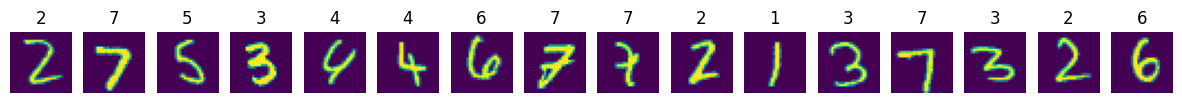

In [43]:
import matplotlib.pyplot as plt

yp = yp.reshape(16, -1)
x = x.reshape(16, 28, 28, 1)

plot_images = iter(x)
labels = iter(yp)
fig, ax = plt.subplots(1, 16, figsize=(15, 15))

for i in range(16):
        ax[i].imshow(next(plot_images))
        ax[i].set_title(str(next(labels)[0]))
        ax[i].axis('off')